# Проект для «Викишоп»

**Описание**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут разрешить и дополнить описание товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать острыее комментарии и отправлять их на модерацию.

**Задача:**

Обучить модель классифицировать комментарии на позитивные и негативные. Необходимо построить модель со значением метрики качества F1 не меньше 0,75.

В наличии набор данных с разметкой о токсичности правок.

## Подготовка

In [1]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.


In [2]:
#импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import nltk 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from nltk.corpus import wordnet
tscv = TimeSeriesSplit(n_splits=5)


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
#откроем датасет
df_toxic = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0], parse_dates=[0])

In [4]:
df_toxic

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0


In [5]:
df_toxic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


По данным имеем датасет с двумя столбцами, 159292 строки.

Коментарии на английском языке. Во втором столбце видим метку - токсичный коментарий или нет, т.е. 1 и 0.

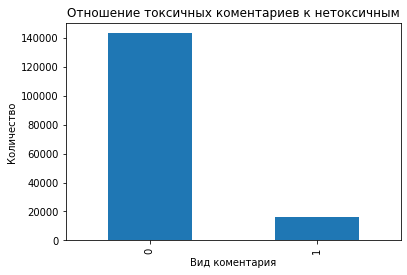

In [6]:
#посмотрим на соотношение токсичных коментариев к нормальным
df_toxic['toxic'].value_counts().plot(kind='bar')
plt.title('Отношение токсичных коментариев к нетоксичным')
plt.xlabel('Вид коментария')
plt.ylabel('Количество')
plt.show()

По графику виден явный дисбаланс. Необходимо учесть этот момент при обучении модели.

Лимитизиуем и очистим текст от символов.

In [8]:
df_toxic['text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [9]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(text.split())

In [10]:
df_toxic['text'] = df_toxic['text'].apply(clear_text)

In [11]:
df_toxic['text'][3]

'More I can t make any real suggestions on improvement I wondered if the section statistics should be later on or a subsection of types of accidents I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up It s listed in the relevant form eg Wikipedia Good article nominations Transport'

In [12]:
# для определения тега «part-of-speech» (POS) для слов текста
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
def lemmatize(text):
    m=WordNetLemmatizer()
    token_list = nltk.word_tokenize(text, get_wordnet_pos(text), preserve_line=True)
    return " ".join([m.lemmatize(w) for w in token_list])


In [14]:
# nltk.download('averaged_perceptron_tagger')
tqdm.pandas()    
df_toxic['text'] = df_toxic['text'].progress_apply(lemmatize)

100%|██████████| 159292/159292 [01:45<00:00, 1508.50it/s]


In [15]:
df_toxic['text'][3]

'More I can t make any real suggestion on improvement I wondered if the section statistic should be later on or a subsection of type of accident I think the reference may need tidying so that they are all in the exact same format ie date format etc I can do that later on if no one else doe first if you have any preference for formatting style on reference or want to do it yourself please let me know There appears to be a backlog on article for review so I guess there may be a delay until a reviewer turn up It s listed in the relevant form eg Wikipedia Good article nomination Transport'

In [16]:
#проверим наличие дубликатов
df_toxic.duplicated().sum()

1156

In [17]:
df_toxic = df_toxic.drop_duplicates()

In [18]:
df_toxic.sample(5)

,text,toxic
131748,Yup they all worked If one failed for any reas...,0
130921,Another One Leo Okay guy we are near done our ...,0
143153,thanks for reformatting WillowW thanks for ref...,0
73588,stop pretending Stop pretending to be cool I d...,1
94460,This event wa a war an internal war between Ja...,0


In [19]:
df_toxic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158136 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    158136 non-null  object
 1   toxic   158136 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Промежуточный вывод по разделу:

В полученном датасете произвели лемматизацию и очистку текстов от лишних символов. Также очистка от дубликатов.

Выяснили, что по столбцу toxic имеем дисбаланс признака.

Данные подготовили к обучению.

## Обучение

In [20]:
#разделим на тренировочную и  тестовую выборки
train, test = train_test_split(df_toxic, test_size=0.2, random_state=12345)
print(train.shape, test.shape)

(126508, 2) (31628, 2)


In [21]:
#создаим корпус
corpus_train = train['text'].values
corpus_test = test['text'].values
target_train = train['toxic']
target_test = test['toxic']
#посмотрим размерность
print(corpus_train.shape, corpus_test.shape)
print(target_train.shape, target_test.shape)

(126508,) (31628,)
(126508,) (31628,)


In [22]:
#вычислим TF-IDF для корпуса текстов, указав стоп-слова:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(min_df=2, stop_words=stopwords) 
tf_idf_train = count_tf_idf.fit_transform(corpus_train) 
tf_idf_test = count_tf_idf.transform(corpus_test) 

print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Размер матрицы: (126508, 59171)
Размер матрицы: (31628, 59171)


Обучим пару моделей: LogisticRegression и RandomForestClassifier

### LogisticRegression

In [23]:
pipe_lr = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('lrc', LogisticRegression(class_weight='balanced'))])

In [24]:
parameters_lr = {
    'tfidf__min_df': range(1, 3, 1),
    'lrc__C': [0.1, 1, 10],
    'lrc__solver': ['newton-cg', 'lbfgs',  'liblinear']
}

In [25]:
rs_model_lr = RandomizedSearchCV(
    pipe_lr,
    parameters_lr, 
    scoring='f1',
    cv=3
)

In [26]:
%%time
rs_model_lr.fit(corpus_train, target_train) 

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

CPU times: user 7min 15s, sys: 4min 24s, total: 11min 39s
Wall time: 11min 40s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words={'a',
                                                                          'about',
                                                                          'above',
                                                                          'after',
                                                                          'again',
                                                                          'against',
                                                                          'ain',
                                                                          'all',
                                                                          'am',
                                                                          'an',
                                                                          'and',
                     

In [27]:
print(f"Значение F1 модели на трейне: {abs(rs_model_lr.best_score_)}")

Значение F1 модели на трейне: 0.7519367943916032


In [28]:
print(f"Оптимальные гиперпараметры для модели: {rs_model_lr.best_params_}")

Оптимальные гиперпараметры для модели: {'tfidf__min_df': 1, 'lrc__solver': 'liblinear', 'lrc__C': 10}


### RandomForestClassifier

In [29]:
pipe_rfc = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('rfc', RandomForestClassifier(class_weight='balanced', random_state=12345))])

In [30]:
parameters_rfc = {
    'rfc__n_estimators': [90, 150],
    'tfidf__min_df': range(1, 3, 1)
}

In [31]:
grid = RandomizedSearchCV(
    pipe_rfc, 
    parameters_rfc, 
    scoring='f1', 
    verbose=3, 
    n_jobs=-1) 

In [32]:
%%time
grid.fit(corpus_train, target_train) 

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 6.8min
[CV 2/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 6.6min
[CV 3/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 6.6min
[CV 4/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 6.5min
[CV 5/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 6.4min
[CV 1/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 4.3min
[CV 2/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 4.4min
[CV 3/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 4.4min
[CV 4/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 4.4min
[CV 5/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 4.5min
[CV 1/5] END .........rfc__n_estimators=150, tfidf__min_df=1; total time=11.5min
[CV 2/5] END .........rfc__n_estimators=150, tfidf__min_df=1; total time=10.7min
[CV 3/5] END .........rfc__n

RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words={'a',
                                                                          'about',
                                                                          'above',
                                                                          'after',
                                                                          'again',
                                                                          'against',
                                                                          'ain',
                                                                          'all',
                                                                          'am',
                                                                          'an',
                                                                          'and',
                                              

In [33]:
print(f"Значение F1 модели на трейне: {grid.best_score_}")
print(f"Оптимальные гиперпараметры для модели: {grid.best_params_}")

Значение F1 модели на трейне: 0.634550104167176
Оптимальные гиперпараметры для модели: {'tfidf__min_df': 2, 'rfc__n_estimators': 150}


По результату имеем:

Модель LogisticRegression: 

Значение F1 модели на трейне: 0.7519805069145854

Оптимальные гиперпараметры для модели: {'tfidf__min_df': 1, 'lrc__solver': 'lbfgs', 'lrc__C': 10}

Модель RandomForestClassifier:

Значение F1 модели на трейне: 0.6366958422334165

Оптимальные гиперпараметры для модели: {'tfidf__min_df': 2, 'rfc__n_estimators': 150}

Произведем расчет f1 меры на модели LogisticRegression., т.к. по удовлетворяет условиюзадачи: f1 > 0.75

In [34]:
#предсказания на тестоовой выборке
prediction = rs_model_lr.predict(corpus_test)

In [35]:
f1_test = round(f1_score(target_test, prediction), 3)
print('Значение f1:', f1_test)

Значение f1: 0.766


## Выводы

Исходный датасет имеет 2 столбца, и 159292 строк.

Произвели очистку текстов комментарий от лишних символов. Произвели лемматизацию. Очистили датасет от дубликатов.

В ходе анализа выяснили, что по признаку toxic, в соотношении токсичныхи нетоксичных комментариях имеем дисбаланс, что учли при проверки моделей.

Было обучено 2 модели: LogisticRegression и RandomForestClassifier.

По условия задания метрика f1 должна быть не менее 0.75. Исходя из этого выбираем модель LogisticRegression.

Значение F1 модели на трейне: 0.7519805069145854

Оптимальные гиперпараметры для модели: {'tfidf__min_df': 1, 'lrc__solver': 'lbfgs', 'lrc__C': 10}

Значение F1 модели на тесте: 0.766.